In [1]:
import numpy as np
import nengo
%matplotlib inline


In [56]:
class FunctionSpace(object):
    def __init__(self, function, n_samples, n_basis, seed=None, pts=None, **distributions):
        self.rng = np.random.RandomState(seed=seed)
        self.function = function
        self.pts = pts
        self.size_output = len(self.call(**distributions))
        
        self.n_basis = n_basis
        data = self.sample(n_samples=n_samples, **distributions)
        self.U, self.S, self.V = np.linalg.svd(data)
        #self.scale = (np.mean(self.S[:self.n_basis])) ** 2
        self.scale = (self.S[0] / self.n_basis) ** 2
        #TODO: which of those scalings works better?
        self.basis = self.V[:self.n_basis].T / np.sqrt(self.scale)
        
    def call(self, function=None, **distributions):
        """Return one sampled instance of the function"""
        if function is None:
            function = self.function
        kwargs = {k:(v.sample(1, rng=self.rng)[0] if isinstance(v, nengo.dists.Distribution) else v) for k, v in distributions.items()}
        return function(self.pts, **kwargs)
    
    def sample(self, function=None, n_samples=1, superimpose=1, **distributions):
        """Sample the function n_samples times, with possible superposition"""
        result = np.zeros((n_samples, self.size_output))
        for i in range(n_samples * superimpose):
            result[i / superimpose] += self.call(function, **distributions)
            #TODO: check if it's faster to sample distributions outside loop
        return result
    
    def project(self, pts):
        """Encode the function from points into the subspace"""
        return np.dot(pts, self.basis)
    
    def reconstruct(self, x):
        """Decode the function from the subspace back to points"""
        return np.dot(x, self.basis.T) * self.scale
        
    def set_encoders(self, ens, function=None, **distributions):
        """Set ensemble encoders by sampling the function"""
        ens.encoders = self.project(self.sample(function=function, n_samples=ens.n_neurons, **distributions))
        
    def set_eval_points(self, ens, function=None, n_eval_points=100, **distributions):
        """Set ensemble eval points by sampling the function"""
        ens.eval_points = self.project(self.sample(function=function, n_samples=n_eval_points, **distributions))
        
        
        

## basic 1D encoding/decoding

In [58]:
# define your function
def gaussian(points, mean, sd):
    return np.exp(-(points-mean)**2/(2*sd**2))

# build the function space
fs = FunctionSpace(gaussian, pts=np.linspace(-1, 1, 2000), 
                   n_samples=1000, n_basis=10,
                   mean=nengo.dists.Uniform(-1, 1), 
                   sd=nengo.dists.Uniform(0.1, 0.7))

# Generate 1 sample
stim = fs.sample(mean=nengo.dists.Uniform(-1, 1), n_samples=1,
                    sd=0.1, 
                    superimpose=4)

# encode it and decode it
decode = fs.reconstruct(fs.project(stim))


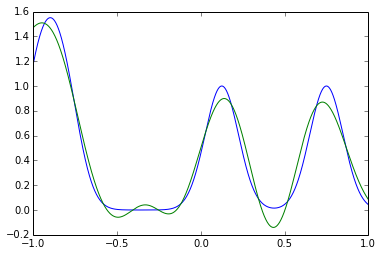

In [59]:
import pylab
pylab.plot(fs.pts, stim[0])
pylab.plot(fs.pts, decode[0])


## Building a Nengo model

In [61]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=500, dimensions=fs.n_basis)
    fs.set_encoders(ens,
                    mean=nengo.dists.Uniform(-1, 1),
                    sd=0.05)
    fs.set_eval_points(ens, n_eval_points=1000,
                       mean=nengo.dists.Uniform(-1, 1),
                       sd=nengo.dists.Uniform(0.1, 0.2))
    
    stimulus = nengo.Node(fs.project(stim)[0])
    nengo.Connection(stimulus, ens)
    
    probe = nengo.Probe(ens, synapse=0.1)
    

In [62]:
sim = nengo.Simulator(model)
sim.run(0.5)

Simulation finished in 0:00:01.                                                 


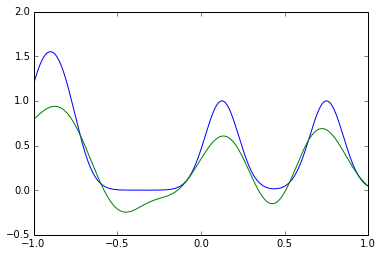

In [65]:
pylab.plot(fs.pts, stim[0])
pylab.plot(fs.pts, fs.reconstruct(sim.data[probe][-1]))


## 2D example

In [66]:
def gaussian2d(points, meanx, meany, sd):
    return np.exp(-((points[:,0]-meanx)**2+(points[:,1]-meany)**2)/(2*sd**2))

pts = np.random.uniform(-1, 1, size=(1000, 2))

fs = FunctionSpace(gaussian2d, pts=pts, 
                   n_samples=1000, n_basis=50,
                   meanx=nengo.dists.Uniform(-1, 1), 
                   meany=nengo.dists.Uniform(-1, 1), 
                   sd=nengo.dists.Uniform(0.1, 0.7))

stim = fs.sample(meanx=nengo.dists.Uniform(-1, 1), 
                    meany=nengo.dists.Uniform(-1,1),
                    n_samples=1,
                    sd=0.2, 
                    superimpose=4)

decode = fs.reconstruct(fs.project(stim[0]))

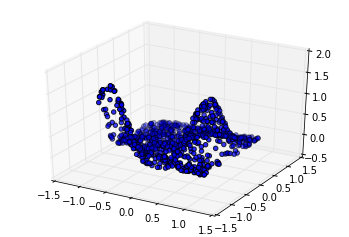

In [67]:
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts[:,0], pts[:,1], decode)

In [70]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=500, dimensions=fs.n_basis)
    fs.set_encoders(ens,
                    meanx=nengo.dists.Uniform(-1, 1),
                    meany=nengo.dists.Uniform(-1, 1),
                    sd=0.05)
    fs.set_eval_points(ens, n_eval_points=1000,
                       meanx=nengo.dists.Uniform(-1, 1),
                       meany=nengo.dists.Uniform(-1, 1),
                       sd=nengo.dists.Uniform(0.1, 0.2))
    
    stimulus = nengo.Node(fs.project(stim)[0])
    nengo.Connection(stimulus, ens)
    
    probe = nengo.Probe(ens, synapse=0.01)
    

In [71]:
sim = nengo.Simulator(model)
sim.run(0.5)

Simulation finished in 0:00:01.                                                 


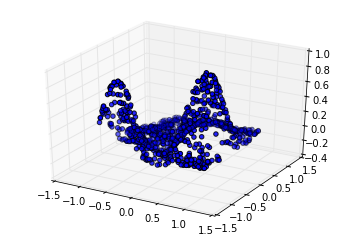

In [72]:
from mpl_toolkits.mplot3d import Axes3D
fig = pylab.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fs.pts[:,0], fs.pts[:,1], fs.reconstruct(sim.data[probe][-1]))